# Classification of DNA Splice Junctions

by Salomon Marquez

25/06/2025  


Splice junctions are points within a DNA sequence where “superfluous” DNA is removed during the protein synthesis process in higher organisms.

The goal of this project is to identify, given a DNA sequence, the boundaries between exons (the parts of the DNA sequence retained after splicing) and introns (the parts of the DNA sequence that are cut out). In the biological community, exon-intron (EI) boundaries are referred to as acceptors, while intron-exon (IE) boundaries are known as donors.

To predict the type of splicing site, several machine learning algorithms will be implemented, including: k-Nearest Neighbour, Naive Bayes, Artificial Neural Network, Support Vector Machine, Decision Tree, and Random Forest. Finally, the following metrics will be evaluated: precision, recall, f1-score, and error, in order to determine which algorithms performed best for this task.

---

## 1 Instalación de dependencias y configuración del directorio de trabajo

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Flatten, Dense, Reshape, Dropout

from IPython.display import Image

In [ ]:
# Fijar semilla para obtener resultados reproducibles cuando se ejecuta el notebook
# Fijar la semilla
seed_value = 123
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
# Obtener el directorio actual
actual_wd = os.getcwd()
print("Ruta actual:", actual_wd)

# Establecer directorio de trabajo en Gdrive
# os.chdir("/content/drive/MyDrive/ASIGNATURAS/M0.163 MACHINE LEARNING/[28 MAY - 17 JUN] RETO 4/PEC4")

In [ ]:
# Visualizar contenido del directorio de trabajo
!ls

autoencoder_image.png	 enunciado_PEC4_2425_2.pdf    splice.csv
deep_descriptors.csv	 PEC4_Machine_Learning.html
deep_descriptors.gsheet  PEC4_Machine_Learning.ipynb


---

## 2 Lectura y preparación de datos
En esta sección responderemos algunas preguntas generales sobre el dataset contenido en el archivo `splice.csv`


### 2.1 Leer datos

In [ ]:
# Especificar el nombre del archivo de origen
file_name = "splice.csv"
file_path = os.path.join(actual_wd, file_name)

In [ ]:
# Guardar en un dataframe el contenido de splice.csv
df_splice = pd.read_csv(file_path, delimiter=',')

In [ ]:
# Visualizar contenido del dataframe splice
df_splice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3190 entries, 0 to 3189
Columns: 482 entries, class to V480
dtypes: int64(480), object(2)
memory usage: 11.7+ MB


In [ ]:
# Visualizar las 5 primeras filas
df_splice.head(5)

,class,seq_name,V1,V2,V3,V4,V5,V6,V7,V8,...,V471,V472,V473,V474,V475,V476,V477,V478,V479,V480
0,EI,ATRINS-DONOR-521,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,EI,ATRINS-DONOR-905,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,EI,BABAPOE-DONOR-30,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,EI,BABAPOE-DONOR-867,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,EI,BABAPOE-DONOR-2817,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Visualizar las 5 últimas filas
df_splice.tail(5)

,class,seq_name,V1,V2,V3,V4,V5,V6,V7,V8,...,V471,V472,V473,V474,V475,V476,V477,V478,V479,V480
3185,N,ORAHBPSBD-NEG-2881,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3186,N,ORAINVOL-NEG-2161,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3187,N,ORARGIT-NEG-241,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3188,N,TARHBB-NEG-541,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3189,N,TARHBD-NEG-1981,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### 2.2 ¿Cuántas `seq_name` únicas tiene el dataset?

In [ ]:
# Obtener el número de secuencias únicas
n_unique = df_splice['seq_name'].nunique()
n_unique

3178

In [ ]:
# Calcular el número de secuencias repetidas
print(f"El dataset contiene {len(df_splice)-n_unique} secuencia repetidas")

El dataset contiene 12 secuencia repetidas


In [ ]:
# Alternativamente para calcular duplicados
df_splice.duplicated().sum()

np.int64(12)

In [ ]:
# Identificar las secuencias repetidas
df_splice_unique = df_splice['seq_name'].value_counts()
df_splice_unique.head(15)

,count
seq_name,
HUMMYC3L-ACCEPTOR-4242,2
HUMALBGC-DONOR-17044,2
HUMMYLCA-DONOR-2559,2
HUMMYLCA-DONOR-2388,2
HUMMYLCA-DONOR-1975,2
HUMMYLCA-DONOR-952,2
HUMALBGC-ACCEPTOR-18496,2
HUMMYLCA-ACCEPTOR-924,2
HUMMYLCA-ACCEPTOR-1831,2


In [ ]:
# Visualizar un par de secuencias repetidas
df_splice[df_splice['seq_name'].str.contains('HUMMYC3L-ACCEPTOR-4242')]

,class,seq_name,V1,V2,V3,V4,V5,V6,V7,V8,...,V471,V472,V473,V474,V475,V476,V477,V478,V479,V480
1316,IE,HUMMYC3L-ACCEPTOR-4242,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1317,IE,HUMMYC3L-ACCEPTOR-4242,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Eliminar duplicados
df_splice_n = df_splice.drop_duplicates()
print(f"El dataset originalmente contenía {len(df_splice)} registros y después de eliminar duplicados se tienen {len(df_splice_n)} registros ")

El dataset originalmente contenía 3190 registros y después de eliminar duplicados se tienen 3178 registros 


### 2.3 ¿Cuántos tipos de etiquetas existen?


In [ ]:
df_splice_label = df_splice_n['class'].value_counts()
df_splice_label

,count
class,
N,1655
IE,762
EI,761


Tenemos un dataset desbalanceado donde poco más del 50% de la secuencias corresponden a la categoría no splicing. Esto se debe tomar en cuenta puesto que los modelos de clasificación propuestos a continuación podrían sesgarse a predecir "N".

### 2.4 Preparar las secuencias codificadas del dataset

En esta sección, definiremos la variable `seq_encoded` que contendrá los 3,178 registros y sus 480 características.

In [ ]:
# Seleccionar desde V1 hasta V480
seq_encoded = df_splice_n.iloc[:,2:]

In [ ]:
# Verificar el tipo de variable
type(seq_encoded)

pandas.core.frame.DataFrame

In [ ]:
# Convertir datos a numpy.array
seq_encoded_array = seq_encoded.to_numpy()
seq_encoded_array[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

### 2.5 Preparar los labels del dataset
La variable `Class` del dataset splicing posse tres categorías EI, IE y N. Aquí no se define una categoría positiva en particular. A continuación, es necesario convertir esta variable en tipo numérica para poder usarla en nuestros modelos de clasificación posteriores.

In [ ]:
labels = df_splice_n['class'].map({'EI': 0, 'IE': 1, 'N': 2})

In [ ]:
# Convertir datos a numpy.array
labels_array = labels.to_numpy()
labels_array[:5]

array([0, 0, 0, 0, 0])

### 2.6 Crear train y test datasets





In [ ]:
# Comprobar que las variables y los labels para entrenar los modelos de clasificación sean tipo array
print(f"La secuencias codificadas por one-hot encoding son de tipo {type(seq_encoded_array)} con dimensión {seq_encoded_array.shape}\n"
      f"y la variable label es de tipo {type(labels_array)} con dimensión {labels_array.shape}")

La secuencias codificadas por one-hot encoding son de tipo <class 'numpy.ndarray'> con dimensión (3178, 480)
y la variable label es de tipo <class 'numpy.ndarray'> con dimensión (3178,)


In [ ]:
# Crear train y test datasets
X_train, X_test, y_train, y_test = train_test_split(
    seq_encoded_array,
    labels_array,
    test_size = 0.33, # 33% para el dataset test como lo indica el enunciado de la PEC4
    random_state= 123 # Fijamos la semilla aleatoria en 123
)

In [ ]:
# Visualizar la dimensiones de los 4 datases creados a partir de train_test_split()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2129, 480), (2129,), (1049, 480), (1049,))

---

## 3 Implementacion del autoencoder convolucional

En esta sección construiremos un autoencoder con la arquitectura que se muestra en la figura y tomando en cuenta el propósito de cada componente como se describe a continuación:

*The encoder is a regular CNN composed of convolutional layers and pooling layers. It typically reduces the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (i.e., the number of feature maps). The decoder must do the reverse (upscale the image and reduce its depth back to the original dimensions), and for this you can use transpose convolutional layers (alternatively, you could combine upsampling layers with convolutional layers)*.
Texto extraído de [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition sección Convolutional Autoencoders.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/ch17.html#id326)

Como las secuencias de ADN son lineales, es decir, una cadena ordenada de nucleótidos entonces utilizaremos `Conv1D` con el fin de detectar motivos locales (como patrones de splicing).

Recordemos también que la única forma de entrenar al componente encoder para que genere representaciones útiles es forzarlo a reconstruir la entrada original. Y es ahí donde interviene el decoder. Sin decoder, no hay aprendizaje del encoder, puesto que no se tendría una métrica para saber si la compresión conserva información útil. Una vez entrenado el decoder, ya podemos usar solo el encoder en los modelos de clasificación posteriores.


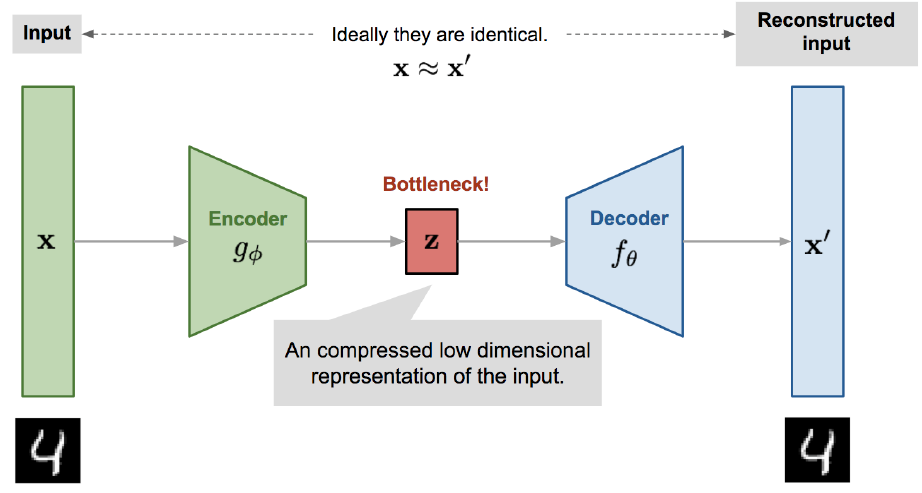

In [ ]:
Image("autoencoder_image.png",width=600, height=400)

In [ ]:
# Reajustar las dimensiones de X_train puesto que Conv1D requiere datos en formato 3D
m, n   = X_train.shape # Dimensiones del dataset train
p, r   = X_test.shape  # Dimensiones del dataset test

X_train_reshaped = X_train.reshape((m, 60, 8))
X_test_reshaped = X_test.reshape((p, 60, 8))

In [ ]:
# AUTOENCODER
# Definir capa de entrada
input_layer = Input(shape=(60, 8))

# Definir encoder
x           = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(input_layer)
bottleneck  = Flatten()(x)
#bottleneck  = Dense(32, activation='relu')(x)

# Definir decoder
#x             = Dense(60 * 8, activation='relu')(bottleneck)
x             = Reshape((60, 8))(bottleneck)
output_layer  = Conv1DTranspose(filters=8, kernel_size=3, activation='sigmoid', padding='same')(x)

# Definir modelo
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entrenar autoencoder
history = autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.7044 - val_loss: 0.6261
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5937 - val_loss: 0.4684
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4215 - val_loss: 0.3057
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2815 - val_loss: 0.2242
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2105 - val_loss: 0.1758
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1660 - val_loss: 0.1404
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1325 - val_loss: 0.1122
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1057 - val_loss: 0.0897
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0842 - val_loss: 0.0718
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0673 - val_loss: 0.0577
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0539 - val_loss: 0.0466
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0435 - val_

In [ ]:
# Evaluar la pérdida de reconstrucción del autoencoder
train_loss  = autoencoder.evaluate(X_train_reshaped, X_train_reshaped)
test_loss   = autoencoder.evaluate(X_test_reshaped, X_test_reshaped)

print(f"\nTrain loss: {train_loss:.4f}")
print(f"Test loss: {test_loss:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101

Train loss: 0.0103
Test loss: 0.0101


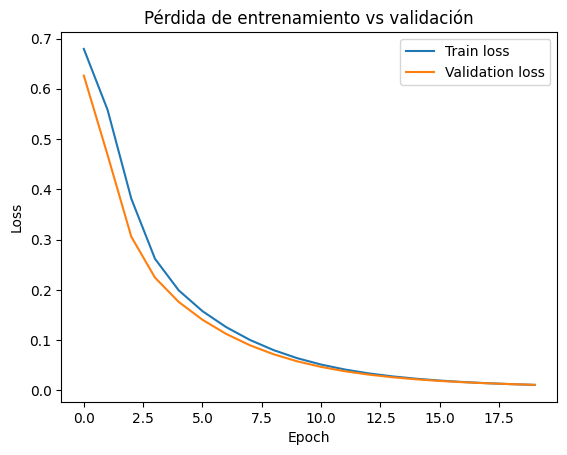

In [ ]:
# Visualizar la curva de entrenamiento del autoencoder
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida de entrenamiento vs validación')
plt.show()

**Observamos que la calidad del autoencoder es buena puesto que la pérdida de reconstrucción es muy baja.**

In [ ]:
# Extraer la parte codificadora "encoder" para usarla en otros modelos
encoder = Model(inputs=input_layer, outputs=bottleneck)
X_train_encoded = encoder.predict(X_train_reshaped)

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Verificar las dimensiones de las nuevas coordenadas de X_train_encoded
X_train_encoded.shape, X_train.shape

((2129, 480), (2129, 480))

In [ ]:
# Visualizar X_train_encoded
print(X_train_encoded)

[[0.41865867 1.1792793  0.         ... 1.0533024  1.2378863  1.4537132 ]
 [0.97194517 1.2243328  0.7337566  ... 1.6940844  0.6968196  2.2641408 ]
 [0.7622293  0.27394313 1.5169445  ... 1.1491497  1.7781353  0.6089502 ]
 ...
 [0.         0.19901627 1.6442008  ... 0.92114854 1.2606764  0.        ]
 [0.55828255 1.0124682  0.6177381  ... 1.4002684  0.5707153  1.0705616 ]
 [0.18931112 0.25097656 1.0731099  ... 2.1333911  0.10522419 1.4503322 ]]


In [ ]:
# Obtener las nuevas coordenadas de X_test
X_test_encoded = encoder.predict(X_test_reshaped)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
# Verificar las dimensiones de las nuevas coordenadas de X_test_encoded
X_test_encoded.shape, X_test.shape

((1049, 480), (1049, 480))

In [ ]:
# Visualizar X_test_encoded
print(X_test_encoded)

[[0.18931112 0.25097656 1.0731099  ... 0.8388007  1.4651122  1.0704793 ]
 [0.55828255 1.0124682  0.6177381  ... 1.4002684  0.5707153  1.0705616 ]
 [0.55828255 1.0124682  0.6177381  ... 0.8388007  1.4651122  1.0704793 ]
 ...
 [0.34228757 1.3086706  0.33683705 ... 1.0533024  1.2378863  1.4537132 ]
 [1.4116294  0.32590342 0.94585365 ... 1.0568092  1.7025597  1.0396074 ]
 [0.16956863 0.1146785  2.0411205  ... 1.7764323  0.49238378 1.1906232 ]]


---

## 4 Aplicación de Algoritmos

### 4.1 Implementar el modelo kNN para k = 1, 3, 5 y 7

Para generar las predicciones del modelo kNN en función del valor de k, creamos una función que implemente las siguientes tareas principales:

1. Crear el modelo
2. Entrenar el modelo
3. Obtener predicciones con el modelo
4. Calcular métricas del modelo

La función tomará como argumentos de entrada el valor de k, `X_train_encoded`, `y_train`, `X_test_encoded` y `y_test` y como salida proporcionará un dataframe de métricas. Comenzamos la creación del modelo kNN para k=3.


In [ ]:
# Crear modelo k-nn con k = 3
k     = 3   # Valor del nearest neighbor k = [1, 3, 5, 7]
model = KNeighborsClassifier(n_neighbors=k, metric='euclidean') # Distancia euclidiana

# Entrenar modelo k-nn
model.fit(X_train_encoded, y_train)

# Hacer predicciones con el modelo k-nn entrenado usando X_test
y_pred = model.predict(X_test_encoded)

# Imprimir reporte de clasificación
# Recordar que {'EI': 0, 'IE': 1, 'N': 2}
print(classification_report(y_test, y_pred, target_names=['Clase EI', 'Clase IE', 'Clase N']))

              precision    recall  f1-score   support

    Clase EI       0.61      0.93      0.74       243
    Clase IE       0.78      0.87      0.82       247
     Clase N       0.96      0.70      0.81       559

    accuracy                           0.79      1049
   macro avg       0.78      0.83      0.79      1049
weighted avg       0.83      0.79      0.79      1049



In [ ]:
# Obtener un dataframe a partir de la matriz de confusion
report             = classification_report(y_test, y_pred, output_dict=True, target_names=['EI', 'IE', 'N'])
df_report          = pd.DataFrame(report).T.loc[['EI', 'IE', 'N']]
df_report['error'] = 1 - df_report['recall']
df_report['k']     = k
df_report['modelo'] = "kNN"
df_report.reset_index(inplace=True)
df_report.rename(columns={'index': 'clase'}, inplace=True)
df_report

,clase,precision,recall,f1-score,support,error,k,modelo
0,EI,0.614754,0.925926,0.738916,243.0,0.074074,3,kNN
1,IE,0.775362,0.866397,0.818356,247.0,0.133603,3,kNN
2,N,0.955774,0.695886,0.805383,559.0,0.304114,3,kNN


In [ ]:
# Definir función evaluar_knn_por_k()
def evaluar_knn_por_k(k, X_train, y_train, X_test, y_test):
    """
    Entrena y evalúa un modelo k-NN con valor k dado.
    Retorna un DataFrame con precision, recall, f1-score, error por clase y k.
    """
    # Entrenar modelo
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model.fit(X_train, y_train)

    # Predicción
    y_pred = model.predict(X_test)

    # Clasification report por clase
    report = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        target_names=['EI', 'IE', 'N']
    )

    # Convertir a DataFrame
    df_report = pd.DataFrame(report).T.loc[['EI', 'IE', 'N']]
    df_report['error'] = 1 - df_report['recall']
    df_report['modelo'] = 'kNN' + ' k=' + str(k)
    df_report.reset_index(inplace=True)
    df_report.rename(columns={'index': 'clase'}, inplace=True)

    return df_report

In [ ]:
# Probar con diferentes valores de k
resultados = []

for k in [1, 3, 5, 7]:
    df_k = evaluar_knn_por_k(k, X_train_encoded, y_train, X_test_encoded, y_test)
    resultados.append(df_k)

# Unir todos los resultados
df_knn_final = pd.concat(resultados, ignore_index=True)
df_knn_final

,clase,precision,recall,f1-score,support,error,modelo
0,EI,0.638554,0.872428,0.737391,243.0,0.127572,kNN k=1
1,IE,0.667722,0.854251,0.749556,247.0,0.145749,kNN k=1
2,N,0.922693,0.661896,0.770833,559.0,0.338104,kNN k=1
3,EI,0.614754,0.925926,0.738916,243.0,0.074074,kNN k=3
4,IE,0.775362,0.866397,0.818356,247.0,0.133603,kNN k=3
5,N,0.955774,0.695886,0.805383,559.0,0.304114,kNN k=3
6,EI,0.684524,0.946502,0.794473,243.0,0.053498,kNN k=5
7,IE,0.751656,0.919028,0.826958,247.0,0.080972,kNN k=5
8,N,0.975669,0.717352,0.826804,559.0,0.282648,kNN k=5
9,EI,0.707317,0.954733,0.812609,243.0,0.045267,kNN k=7


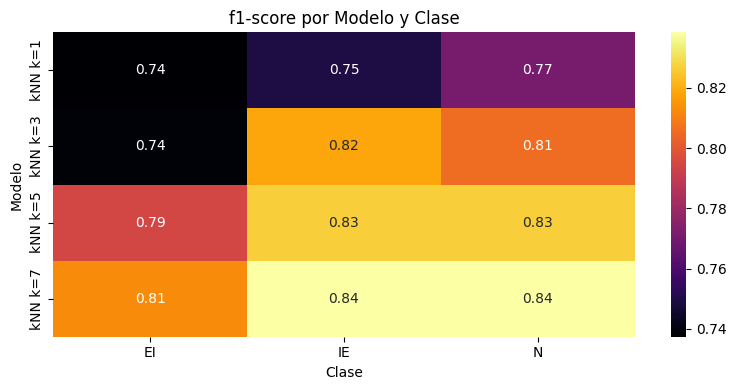

In [ ]:
# Graficar el f1-score por modelo y clase
pivot_f1_score = df_knn_final.pivot_table(index='modelo', columns='clase', values='f1-score', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_f1_score, annot=True, cmap='inferno', fmt=".2f")
plt.title('f1-score por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

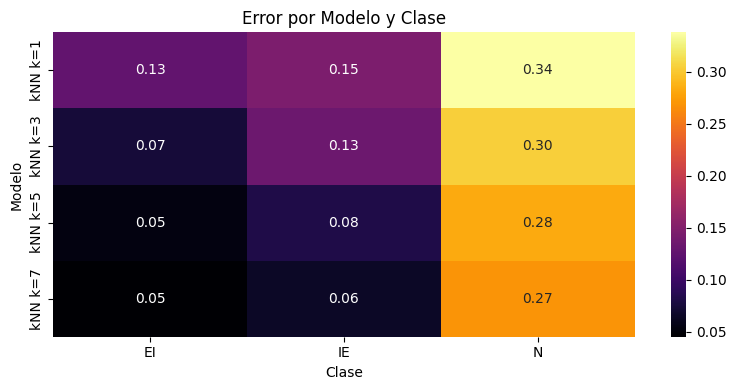

In [ ]:
# Graficar la error por modelo y clase
pivot_error = df_knn_final.pivot_table(index='modelo', columns='clase', values='error', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_error, annot=True, cmap='inferno', fmt=".2f")
plt.title('Error por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
### 4.1 Implementar el modelo kNN para k = 1, 3, 5 y 7
plt.show()

### Comentario sobre el desempeño del modelo kNN

La estrategia modelo que se seguirá para evaluar los modelos es la siguiente:

- Observar f1-score ya que es la métrica más equilibrada si hay un trate-off entre precision y recall especialmente en tareas de clasificación multicategórica.
- Estudiar el error
- Evaluar el rendimiento del modelo por clase para asegurarnos de no optimizar la predicción de una clase en partícular, como sería el caso de N.

El modelo k-Nearest Neighbors (kNN) muestra una mejora progresiva del f1-score conforme aumenta el valor de k, lo que indica mayor robustez a medida que se consideran más vecinos. De forma inversa, el error disminuye, lo que respalda esta mejora en desempeño.

Al analizar el f1-score por clase, se nota que las clases IE y N tienen un rendimiento más consistente, mientras que el modelo tiene más dificultad para identificar correctamente la categoría EI. Finalmente, llama la atención que la clase N presente el error más alto, lo que indica que el modelo aún puede seguir mejorando.

---

### 4.2 Implementar el modelo Naive Bayes

Para evaluar el rendimiento del modelo Naive Bayes según el tipo de datos en Python, se plantean dos enfoques. Primero, se emplea el clasificador BernoulliNB con suavizado de Laplace (alpha = 1, en Python) sobre datos binarios obtenidos mediante codificación one-hot. A continuación, se utiliza GaussianNB sobre datos continuos derivados del autoencoder convolucional, dado que este modelo asume una distribución normal de las variables. Esta estrategia permitirá comparar el impacto de distintas transformaciones de entrada en el desempeño del clasificador Naive Bayes.

Para mayor información sobre la implementación del modelo Naive Bayes consultar [BernoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) y [GausssianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html).

In [ ]:
# Entrenar BernoulliNB sin suavizado (alpha=0) con datos one-hot encoded
modelNB_alpha0 = BernoulliNB(alpha=0.0)
modelNB_alpha0.fit(X_train, y_train)

# Predecir
y_pred_NB_alpha0 = modelNB_alpha0.predict(X_test)
print("Predicciones:", y_pred_NB_alpha0)

Predicciones: [0 0 0 ... 0 0 0]


/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:1209: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
# Obtener un dataframe a partir de la matriz de confusion
report_NB_alpha0              = classification_report(y_test, y_pred_NB_alpha0, output_dict=True, target_names=['EI', 'IE', 'N'])
df_report_NB_alpha0           = pd.DataFrame(report_NB_alpha0 ).T.loc[['EI', 'IE', 'N']]
df_report_NB_alpha0 ['error'] = 1 - df_report_NB_alpha0 ['recall']
df_report_NB_alpha0 ['modelo']  = "Bernoulli B alpha=0"
df_report_NB_alpha0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support,error,modelo
EI,0.231649,1.0,0.376161,243.0,0.0,Bernoulli B alpha=0
IE,0.000000,0.0,0.000000,247.0,1.0,Bernoulli B alpha=0
N,0.000000,0.0,0.000000,559.0,1.0,Bernoulli B alpha=0


In [ ]:
# Entrenar BernoulliNB con suavizado (alpha=1) con datos one-hot encoded
modelNB_alpha1 = BernoulliNB(alpha=1.0)
modelNB_alpha1.fit(X_train, y_train)

# Predecir
y_pred_NB_alpha1 = modelNB_alpha0.predict(X_test)
print("Predicciones:", y_pred_NB_alpha1)

Predicciones: [0 0 0 ... 0 0 0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
# Obtener un dataframe a partir de la matriz de confusion
report_NB_alpha1             = classification_report(y_test, y_pred_NB_alpha1, output_dict=True, target_names=['EI', 'IE', 'N'])
df_report_NB_alpha1          = pd.DataFrame(report_NB_alpha1).T.loc[['EI', 'IE', 'N']]
df_report_NB_alpha1['error'] = 1 - df_report_NB_alpha1['recall']
df_report_NB_alpha1['modelo']  = "BernoulliNB alpha=1"
df_report_NB_alpha1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support,error,modelo
EI,0.231649,1.0,0.376161,243.0,0.0,BernoulliNB alpha=1
IE,0.000000,0.0,0.000000,247.0,1.0,BernoulliNB alpha=1
N,0.000000,0.0,0.000000,559.0,1.0,BernoulliNB alpha=1


In [ ]:
# Entrenar GaussianNB con datos del autoencoder
modelNB = GaussianNB()
modelNB.fit(X_train_encoded, y_train)

# Predecir
y_pred_NB = modelNB.predict(X_test_encoded)
print("Predicciones:", y_pred_NB)

Predicciones: [1 1 2 ... 0 2 1]


In [ ]:
# Obtener un dataframe a partir de la matriz de confusion
report_NB             = classification_report(y_test, y_pred_NB, output_dict=True, target_names=['EI', 'IE', 'N'])
df_report_NB          = pd.DataFrame(report_NB).T.loc[['EI', 'IE', 'N']]
df_report_NB['error'] = 1 - df_report_NB['recall']
df_report_NB['modelo']  = "GaussianNB"
df_report_NB

,precision,recall,f1-score,support,error,modelo
EI,0.942623,0.946502,0.944559,243.0,0.053498,GaussianNB
IE,0.917647,0.947368,0.932271,247.0,0.052632,GaussianNB
N,0.983636,0.967800,0.975654,559.0,0.032200,GaussianNB


In [ ]:
# Unir todos los resultados
df_naivebayes_final = pd.concat([df_report_NB_alpha0, df_report_NB_alpha1, df_report_NB]).reset_index().rename(columns={'index': 'clase'})
df_naivebayes_final

,clase,precision,recall,f1-score,support,error,modelo
0,EI,0.231649,1.000000,0.376161,243.0,0.000000,Bernoulli B alpha=0
1,IE,0.000000,0.000000,0.000000,247.0,1.000000,Bernoulli B alpha=0
2,N,0.000000,0.000000,0.000000,559.0,1.000000,Bernoulli B alpha=0
3,EI,0.231649,1.000000,0.376161,243.0,0.000000,BernoulliNB alpha=1
4,IE,0.000000,0.000000,0.000000,247.0,1.000000,BernoulliNB alpha=1
5,N,0.000000,0.000000,0.000000,559.0,1.000000,BernoulliNB alpha=1
6,EI,0.942623,0.946502,0.944559,243.0,0.053498,GaussianNB
7,IE,0.917647,0.947368,0.932271,247.0,0.052632,GaussianNB
8,N,0.983636,0.967800,0.975654,559.0,0.032200,GaussianNB


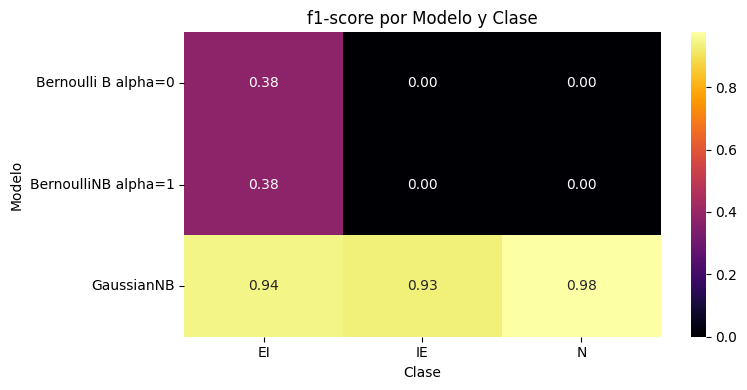

In [ ]:
# Graficar el f1-score por modelo y clase
pivot_f1_score = df_naivebayes_final.pivot_table(index='modelo', columns='clase', values='f1-score', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_f1_score, annot=True, cmap='inferno', fmt=".2f")
plt.title('f1-score por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

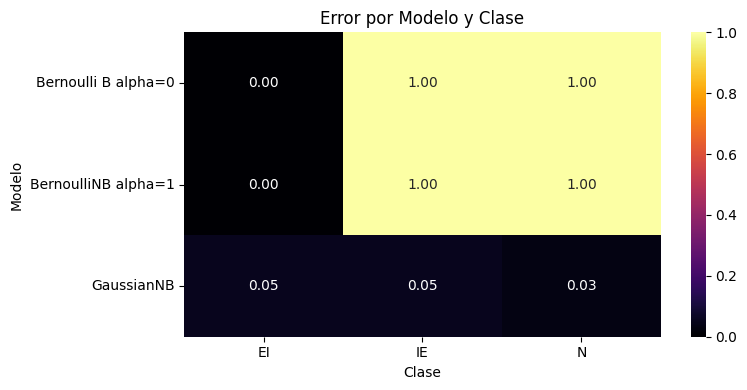

In [ ]:
# Graficar la error por modelo y clase
pivot_error = df_naivebayes_final.pivot_table(index='modelo', columns='clase', values='error', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_error, annot=True, cmap='inferno', fmt=".2f")
plt.title('Error por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

### Comentario sobre el desempeño del modelo Naive Bayes

Como se mencionó al inicio de esta sección, se probaron dos variantes de Naive Bayes: BernoulliNB (para evaluar el suavizado de Laplace) y GaussianNB.

El modelo BernoulliNB, que utilizó datos codificados mediante one-hot encoding, no logró resultados útiles. Esto se debe a que los datos binarios derivados de secuencias de ADN tienden a ser dispersos y altamente correlacionados, lo cual dificulta que el modelo capte patrones relevantes, especialmente considerando que BernoulliNB asume independencia entre características.

En contraste, el modelo GaussianNB que se alimentó de los datos transformados por el encoder, mostró un rendimiento muy sólido. Alcanzó valores de f1-score altos y consistentes entre las tres clases, así como errores muy bajos.

---

### 4.3 Implementar el modelo Artificial Neural Network

En esta sección se construye una red neuronal artificial cuya arquitectura contiene dos capas ocultas de 100 y p nodos, donde se explorará el número de nodos p = 5, 10 y 20. Comenzamos el modelo para el valor de p = 20 y posteriormente escalaremos el número de nodos.

In [ ]:
# Definir nodo
p = 20

In [ ]:
# Definir la arquitectura de la ANN
model = Sequential([
    Input(shape=(X_train_encoded.shape[1],)),
    Dense(100, activation='relu'),
    Dense(p, activation='relu'),
    Dense(3, activation='softmax') # Ya que se tienen más de 2 categorías
    ])

In [ ]:
# Ver detalles del modelo
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 100)            │        48,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,183 (196.03 KB)

 Trainable params: 50,183 (196.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilar modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Puesto que las categorías de y_train son enteras [0, 1, 2]
              metrics=['accuracy'])

In [ ]:
# Definir épocas, tamaño del batch y entrenar el modelo
n_batch  = 32
n_epochs = 20

mfit = model.fit(X_train_encoded, y_train,
          epochs=n_epochs,
          batch_size=n_batch)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5665 - loss: 0.9898
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8900 - loss: 0.3338
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9415 - loss: 0.1934
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9525 - loss: 0.1493
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9655 - loss: 0.1159
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9739 - loss: 0.0986
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9715 - loss: 0.0910
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9725 - loss: 0.0824
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9725 - loss: 0.0859
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9717 - loss: 0.0829
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9720 - loss: 0.0820
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9534 - lo

In [ ]:
# Evaluar modelo
loss, acc     = model.evaluate(X_test_encoded, y_test)
y_pred        = model.predict(X_test_encoded)
y_pred_labels = y_pred.argmax(axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8993 - loss: 0.2753
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Visualizar las primeras predicciones
y_pred_labels[:100]

array([1, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 2, 0, 2, 0,
       1, 2, 2, 2, 0, 2, 2, 2, 0, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 0, 1, 2, 0, 2,
       2, 0, 2, 1, 2, 1, 1, 2, 1, 0, 2, 0, 1, 2, 2, 0, 2, 1, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 1])

In [ ]:
# Visualizar los truth labels
y_test[:100]

array([1, 1, 2, 2, 2, 1, 2, 1, 0, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0,
       1, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2, 2, 1, 2, 0, 2, 2, 1, 2, 1,
       2, 2, 2, 1, 2, 2, 0, 0, 2, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 2, 0, 2,
       1, 0, 2, 1, 2, 1, 1, 2, 1, 0, 1, 0, 1, 2, 2, 0, 2, 1, 2, 1, 1, 2,
       1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 1])

In [ ]:
# Obtener reporte de clasificación
report              = classification_report(y_test, y_pred_labels, output_dict=True, target_names=['EI', 'IE', 'N'])
df_report           = pd.DataFrame(report).T.loc[['EI', 'IE', 'N']]
df_report['error']  = 1 - df_report['recall']
df_report['modelo'] = 'ANN'
df_report['p']      = p
df_report

,precision,recall,f1-score,support,error,modelo,p
EI,0.932773,0.913580,0.923077,243.0,0.086420,ANN,20
IE,0.982659,0.688259,0.809524,247.0,0.311741,ANN,20
N,0.873041,0.996422,0.930660,559.0,0.003578,ANN,20


In [ ]:
# Validar el modelo ANN con distintos valores de p = [5, 10, 20]

# Lista para guardar resultados
resultados_ann = []

for p in [5, 10, 20]:
    print(f"\nEntrenando red con p = {p} nodos en segunda capa oculta...")

    # Definir modelo
    model = Sequential([
        Input(shape=(X_train_encoded.shape[1],)),
        Dense(100, activation='relu'),
        Dense(p, activation='relu'),
        Dense(3, activation='softmax')  # 3 clases
    ])

    # Compilar
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Entrenar
    model.fit(X_train_encoded, y_train, epochs=20, batch_size=32)

    # Evaluar
    loss, acc = model.evaluate(X_test_encoded, y_test)
    y_pred = model.predict(X_test_encoded)
    y_pred_labels = y_pred.argmax(axis=1)

    # Reporte de clasificación
    report = classification_report(y_test, y_pred_labels, output_dict=True, target_names=['EI', 'IE', 'N'])
    df_report = pd.DataFrame(report).T.loc[['EI', 'IE', 'N']]
    df_report['error'] = 1 - df_report['recall']
    df_report['modelo'] = 'ANN' + ' p=' + str(p)
    resultados_ann.append(df_report)


Entrenando red con p = 5 nodos en segunda capa oculta...
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4817 - loss: 1.0251
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7174 - loss: 0.7122
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7311 - loss: 0.6508
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7394 - loss: 0.6104
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7355 - loss: 0.5964
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7436 - loss: 0.5715
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7389 - loss: 0.5576
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7482 - loss: 0.5414
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7461 - loss: 0.5322
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7450 - loss: 0.5276
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7442 - loss: 0.5433
Epoch 12/20
67/6

In [ ]:
# Concatenar resultados
df_ann_final = pd.concat(resultados_ann).reset_index().rename(columns={'index': 'clase'})

# Mostrar resultados
print("Resultados por clase para cada valor de p:")
df_ann_final

Resultados por clase para cada valor de p:


,clase,precision,recall,f1-score,support,error,modelo
0,EI,0.954733,0.954733,0.954733,243.0,0.045267,ANN p=5
1,IE,0.877323,0.955466,0.914729,247.0,0.044534,ANN p=5
2,N,0.990689,0.951699,0.970803,559.0,0.048301,ANN p=5
3,EI,0.881481,0.979424,0.927875,243.0,0.020576,ANN p=10
4,IE,0.906504,0.902834,0.904665,247.0,0.097166,ANN p=10
5,N,0.984991,0.939177,0.961538,559.0,0.060823,ANN p=10
6,EI,0.960870,0.909465,0.934461,243.0,0.090535,ANN p=20
7,IE,0.925620,0.906883,0.916155,247.0,0.093117,ANN p=20
8,N,0.944541,0.974955,0.959507,559.0,0.025045,ANN p=20


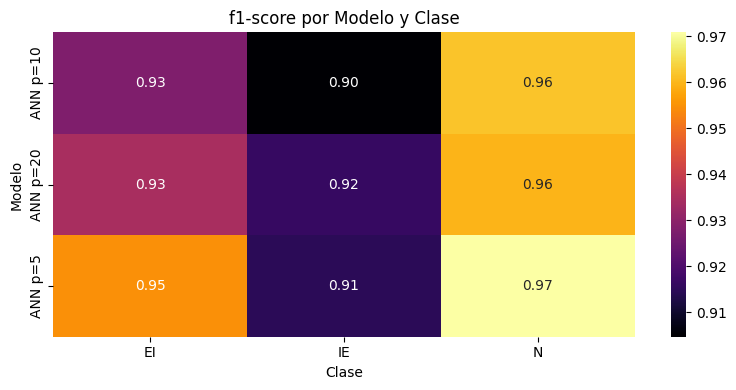

In [ ]:
# Graficar el f1-score por modelo y clase
pivot_f1_score = df_ann_final.pivot_table(index='modelo', columns='clase', values='f1-score', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_f1_score, annot=True, cmap='inferno', fmt=".2f")
plt.title('f1-score por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

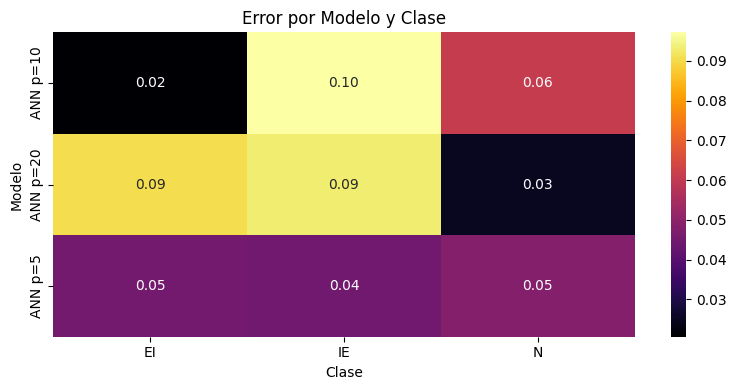

In [ ]:
# Graficar la error por modelo y clase
pivot_error = df_ann_final.pivot_table(index='modelo', columns='clase', values='error', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_error, annot=True, cmap='inferno', fmt=".2f")
plt.title('Error por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

### Comentario sobre el desempeño del modelo ANN

El modelo de red neuronal artificial (ANN) presenta un rendimiento sólido en general, con valores de f1-score altos y consistentes en todas las clases. A medida que se incrementa el número de nodos de la 2da. capa oculta (p), el f1-score se sostiene aunque sin mejoras tan claras como las observadas en el modelo kNN respecto al valor de k.

En relación a las clases, la clase N tiene el mejor desempeño con f1-scores superiores al 0.96 y errores mínimos. Y en desempeño le sigue la clase EI, sin embargo, la clase IE presenta un aumento del error cuando p sube de 5 a 10, lo cual sugiere un posible sobreajuste.

---

### 4.4 Implementar el modelo Support Vector Machine
En esta sección se construye un modelo de Máquina de Vector de Soporte con dos tipos de configuraciones: `kernel lineal` y `rbf`. Comenzamos con la implementación del primero de ellos.

In [ ]:
# Crear modelo SVM
model = SVC(kernel='linear')

In [ ]:
# Entrenar el modelo
model.fit(X_train_encoded, y_train)

SVC(kernel='linear')

In [ ]:
# Hacer Predicciones
y_pred = model.predict(X_test_encoded)

In [ ]:
# Crear reporte de clasificación
report = classification_report(
    y_test,
    y_pred,
    output_dict=True,
    target_names=['EI', 'IE', 'N']
    )

In [ ]:
# Crear DataFrame con métricas por clase
df_report = pd.DataFrame(report).T.loc[['EI', 'IE', 'N']]
df_report['error'] = 1 - df_report['recall']
df_report['kernel'] = 'lineal'
df_report

,precision,recall,f1-score,support,error,kernel
EI,0.882129,0.954733,0.916996,243.0,0.045267,lineal
IE,0.905738,0.894737,0.900204,247.0,0.105263,lineal
N,0.968635,0.939177,0.953678,559.0,0.060823,lineal


In [ ]:
# Explorar las dos opciones de kernel lineal y rbf

# Lista para almacenar resultados
resultados_svm = []

# Definir kernels a evaluar
for kernel in ['linear', 'rbf']:
    print(f"\nEntrenando SVM con kernel = '{kernel}'...")

    # Crear modelo SVM
    model = SVC(kernel=kernel)

    # Entrenar el modelo
    model.fit(X_train_encoded, y_train)

    # Predicciones
    y_pred = model.predict(X_test_encoded)

    # Reporte de clasificación
    report = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        target_names=['EI', 'IE', 'N']
    )

    # Crear DataFrame con métricas por clase
    df_report = pd.DataFrame(report).T.loc[['EI', 'IE', 'N']]
    df_report['error'] = 1 - df_report['recall']
    df_report['modelo'] = "SVM " + kernel
    resultados_svm.append(df_report)


Entrenando SVM con kernel = 'linear'...

Entrenando SVM con kernel = 'rbf'...


In [ ]:
# Concatenar resultados
df_svm_final = pd.concat(resultados_svm).reset_index().rename(columns={'index': 'clase'})

# Mostrar tabla final
print("Resultados por clase para cada kernel:")
df_svm_final

Resultados por clase para cada kernel:


,clase,precision,recall,f1-score,support,error,modelo
0,EI,0.882129,0.954733,0.916996,243.0,0.045267,SVM linear
1,IE,0.905738,0.894737,0.900204,247.0,0.105263,SVM linear
2,N,0.968635,0.939177,0.953678,559.0,0.060823,SVM linear
3,EI,0.947791,0.971193,0.959350,243.0,0.028807,SVM rbf
4,IE,0.931727,0.939271,0.935484,247.0,0.060729,SVM rbf
5,N,0.985481,0.971377,0.978378,559.0,0.028623,SVM rbf


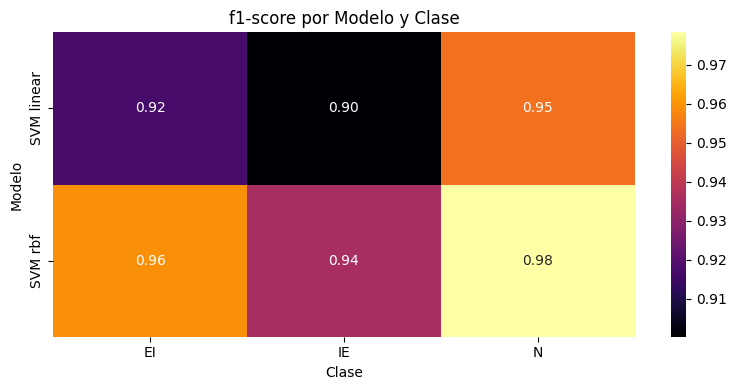

In [ ]:
# Graficar el f1-score por modelo y clase
pivot_f1_score = df_svm_final.pivot_table(index='modelo', columns='clase', values='f1-score', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_f1_score, annot=True, cmap='inferno', fmt=".2f")
plt.title('f1-score por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

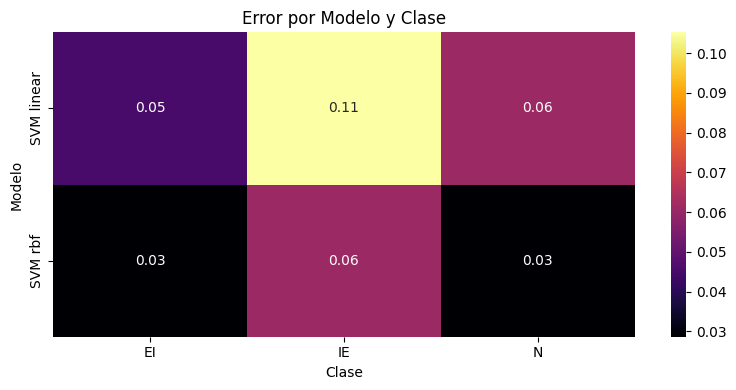

In [ ]:
# Graficar la error por modelo y clase
pivot_error = df_svm_final.pivot_table(index='modelo', columns='clase', values='error', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_error, annot=True, cmap='inferno', fmt=".2f")
plt.title('Error por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

### Comentario sobre el desempeño del modelo SVM (Linear y RBF)

El modelo SVM con kernel lineal ofrece un rendimiento aceptable, con f1-scores por encima de 0.90 en todas las clases. El mejor desempeño lo tiene la clase N, mientras que la clase IE es la que presenta más error.

Por otro lado, el modelo SVM con kernel RBF presenta mejores f1-scores (> 0.94), con errores considerablemente más bajos. El salto de calidad se nota especialmente en la clase EI e IE, mientras que N también mejora, con un rendimiento más equilibrado y consistente.

En resumen, el modelo SVM con kernel RBF supera al lineal en todas las métricas relevantes, mostrando mejor generalización.

---

### 4.5 Implementar el modelo Árbol de Clasificación
En esta sección se construye un modelo de árbol de clasificación con dos tipos de configuraciones: `boosting` y `no boosting`.


In [ ]:
# Definir la función evaluar_model_arbol()

def evaluar_modelo_arbol(boosting=False, max_depth=None):
    # Seleccionar modelo
    if boosting:
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=max_depth, random_state=42)
        nombre_modelo = 'Árbol con Boosting'
    else:
        model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        nombre_modelo = 'Árbol de Decisión'

    # Entrenar
    model.fit(X_train_encoded, y_train)

    # Predecir
    y_pred = model.predict(X_test_encoded)

    # Reporte de clasificación
    report = classification_report(
        y_test, y_pred,
        output_dict=True,
        target_names=['EI', 'IE', 'N']
    )

    # Formatear DataFrame
    df_report               = pd.DataFrame(report).T.loc[['EI', 'IE', 'N']]
    df_report['error']      = 1 - df_report['recall']
    df_report['modelo']     = nombre_modelo + ' depth=' + str(max_depth)

    return df_report

In [ ]:
# Evaluar ambos modelos
df_arbol = evaluar_modelo_arbol(boosting=False, max_depth=5)
df_boost = evaluar_modelo_arbol(boosting=True, max_depth=5)

# Combinar resultados
df_arboles_final = pd.concat([df_arbol, df_boost]).reset_index().rename(columns={'index': 'clase'})

# Mostrar
df_arboles_final

,clase,precision,recall,f1-score,support,error,modelo
0,EI,0.893130,0.962963,0.926733,243.0,0.037037,Árbol de Decisión depth=5
1,IE,0.946429,0.858300,0.900212,247.0,0.141700,Árbol de Decisión depth=5
2,N,0.959147,0.966011,0.962567,559.0,0.033989,Árbol de Decisión depth=5
3,EI,0.932540,0.967078,0.949495,243.0,0.032922,Árbol con Boosting depth=5
4,IE,0.942857,0.935223,0.939024,247.0,0.064777,Árbol con Boosting depth=5
5,N,0.983696,0.971377,0.977498,559.0,0.028623,Árbol con Boosting depth=5


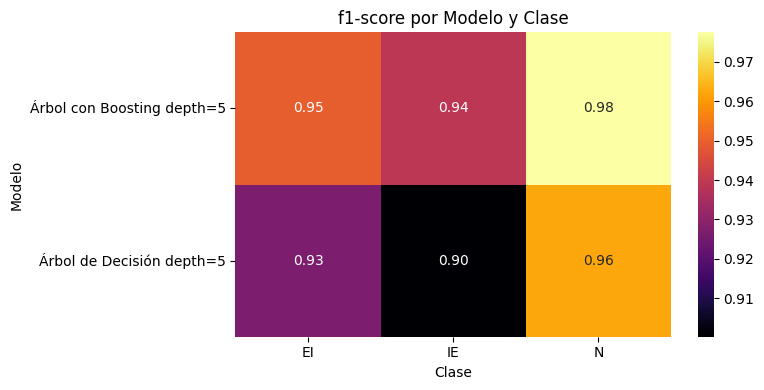

In [ ]:
# Graficar el f1-score por modelo y clase
pivot_f1_score = df_arboles_final.pivot_table(index='modelo', columns='clase', values='f1-score', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_f1_score, annot=True, cmap='inferno', fmt=".2f")
plt.title('f1-score por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

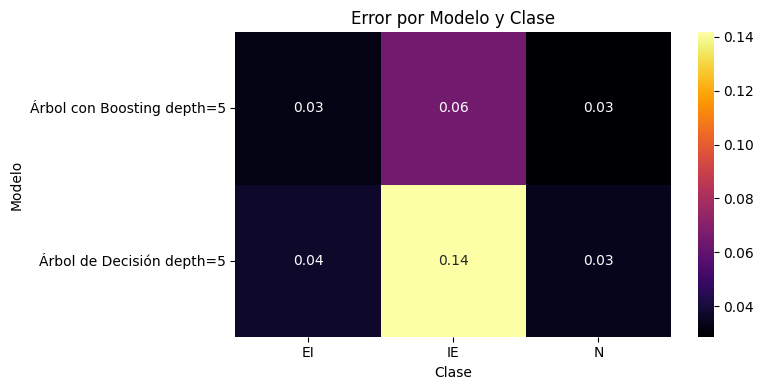

In [ ]:
# Graficar la error por modelo y clase
pivot_error = df_arboles_final.pivot_table(index='modelo', columns='clase', values='error', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_error, annot=True, cmap='inferno', fmt=".2f")
plt.title('Error por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

### Comentario sobre el modelo Árbol de Clasificación

El modelo árbol de decisión con profundidad 5 presenta un rendimiento sólido, con f1-scores superiores al 0.90 en todas las clases y errores bajos. Destaca especialmente la clase N, que mantiene un f1-score de 0.96, mientras que EI e IE muestran un comportamiento estable, aunque IE presenta un error mayor.

Al aplicar Boosting sobre el árbol, se observa una mejora clara en todas las métricas. El f1-score se incrementa ligeramente en todas las clases, alcanzando valores por encima de 0.94. Los errores también disminuyen, en especial para la clase IE.

En resumen, el Árbol con Boosting ofrece un rendimiento más alto y más consistente. La combinación de Boosting y árboles poco profundos parece capturar mejor la estructura del problema sin sobreajustar.

---

### 4.6 Implementar el modelo Random Forest con n = 50 y 100
En esta sección se construye un modelo de Random Forest con dos números de árboles: `n=50` y `n=100`.

In [ ]:
# Definir la función evaluar_random_forest()
def evaluar_random_forest(n_estimators):
    # Inicializar modelo
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Entrenar
    model.fit(X_train_encoded, y_train)

    # Predecir
    y_pred = model.predict(X_test_encoded)

    # Obtener reporte por clase
    report = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        target_names=['EI', 'IE', 'N']
    )

    # Formatear resultado en DataFrame
    df_report = pd.DataFrame(report).T.loc[['EI', 'IE', 'N']]
    df_report['error'] = 1 - df_report['recall']
    df_report['modelo'] = 'Random Forest' + ' n=' + str(n_estimators)

    return df_report

In [ ]:
# Evaluar Random Forest con 50 y 100 árboles
df_rf_50  = evaluar_random_forest(n_estimators=50)
df_rf_100 = evaluar_random_forest(n_estimators=100)

# Combinar resultados
df_rf_total = pd.concat([df_rf_50, df_rf_100]).reset_index().rename(columns={'index': 'clase'})

# Mostrar resultados
df_rf_total

,clase,precision,recall,f1-score,support,error,modelo
0,EI,0.925197,0.967078,0.945674,243.0,0.032922,Random Forest n=50
1,IE,0.941909,0.919028,0.930328,247.0,0.080972,Random Forest n=50
2,N,0.983755,0.974955,0.979335,559.0,0.025045,Random Forest n=50
3,EI,0.928854,0.967078,0.947581,243.0,0.032922,Random Forest n=100
4,IE,0.937759,0.914980,0.926230,247.0,0.085020,Random Forest n=100
5,N,0.980180,0.973166,0.976661,559.0,0.026834,Random Forest n=100


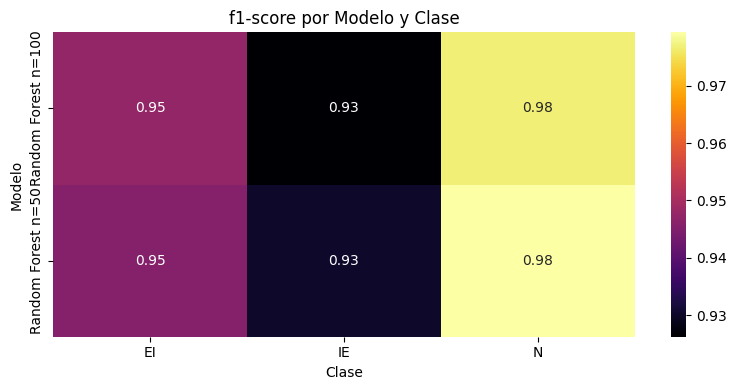

In [ ]:
# Graficar el f1-score por modelo y clase
pivot_f1_score = df_rf_total.pivot_table(index='modelo', columns='clase', values='f1-score', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_f1_score, annot=True, cmap='inferno', fmt=".2f")
plt.title('f1-score por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

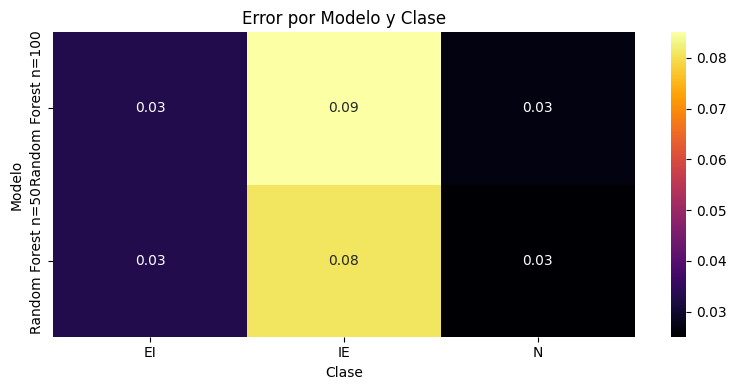

In [ ]:
# Graficar la error por modelo y clase
pivot_error = df_rf_total.pivot_table(index='modelo', columns='clase', values='error', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_error, annot=True, cmap='inferno', fmt=".2f")
plt.title('Error por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

### Comentario sobre el modelo Random Forest

El modelo Random Forest con 50 árboles muestra un rendimiento muy competitivo. Los f1-scores superan el 0.93 en todas las clases, destacando especialmente la clase N. Los errores son bajos y bastante equilibrados entre las clases, con excepción de la clase IE, lo que indica una buena capacidad de generalización.

Al incrementar el número de árboles a 100, no se observan  mejoras. El f1-score se mantiene en todas las clases, y el error se mantiene bajo. Este comportamiento nos sugiere que podríamos aumentar la cantidad de árboles para ayudar a estabilizar y afinar la predicción, aunque el desempeño actual ya parece suficiente.


---

## 5 Comparación del desempeño de los modelos propuestos

In [ ]:
# Crear tabla comparativa de todos los modelos implementados
# Combinar resultados
df_resultado_modelos = pd.concat([df_knn_final, df_naivebayes_final, df_ann_final, df_svm_final, df_arboles_final, df_rf_total]).reset_index(drop=True)

# Mostrar resultados
df_resultado_modelos

,clase,precision,recall,f1-score,support,error,modelo
0,EI,0.633929,0.876543,0.735751,243.0,0.123457,kNN k=1
1,IE,0.662420,0.842105,0.741533,247.0,0.157895,kNN k=1
2,N,0.919799,0.656530,0.766180,559.0,0.343470,kNN k=1
3,EI,0.630986,0.921811,0.749164,243.0,0.078189,kNN k=3
4,IE,0.763699,0.902834,0.827458,247.0,0.097166,kNN k=3
5,N,0.965174,0.694097,0.807492,559.0,0.305903,kNN k=3
6,EI,0.665698,0.942387,0.780239,243.0,0.057613,kNN k=5
7,IE,0.719136,0.943320,0.816112,247.0,0.056680,kNN k=5
8,N,0.989501,0.674419,0.802128,559.0,0.325581,kNN k=5
9,EI,0.728707,0.950617,0.825000,243.0,0.049383,kNN k=7


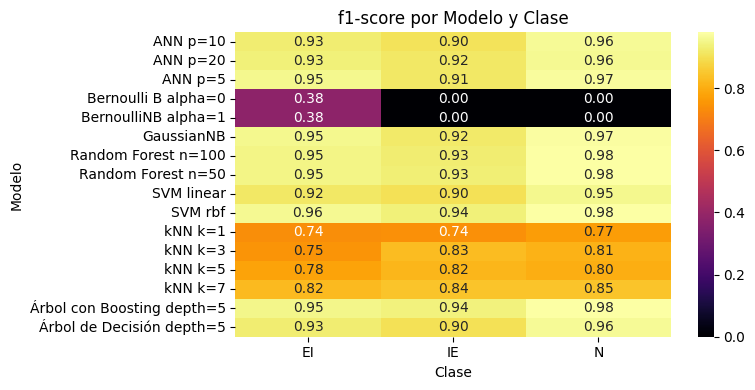

In [ ]:
# Graficar el f1-score por modelo y clase
pivot_f1_score = df_resultado_modelos.pivot_table(index='modelo', columns='clase', values='f1-score', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_f1_score, annot=True, cmap='inferno', fmt=".2f")
plt.title('f1-score por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

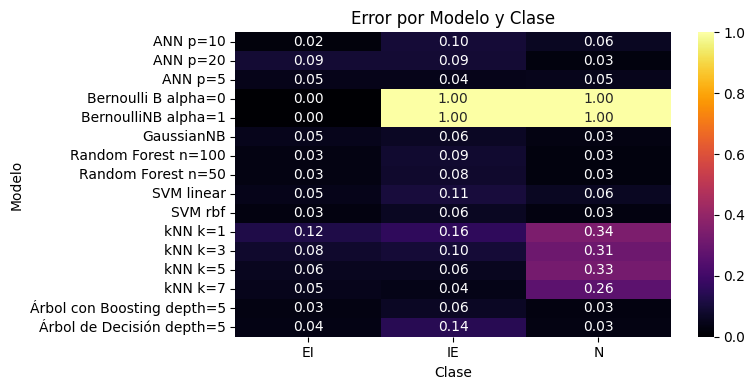

In [ ]:
# Graficar el error por modelo y clase
pivot_error = df_resultado_modelos.pivot_table(index='modelo', columns='clase', values='error', aggfunc='mean')
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_error, annot=True, cmap='inferno', fmt=".2f")
plt.title('Error por Modelo y Clase')
plt.ylabel('Modelo')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

### Comentario global sobre la elección de modelos

En el contexto de este proyecto, donde el objetivo es predecir sitios de splicing (clases EI e IE), es fundamental elegir modelos que no solo alcancen buenos f1-scores globales, sino que sean precisos en estas clases, sin confundir regiones de no splicing (clase N).

Entre los modelos con mejor desempeño para esta tarea encontramos SVM RBF, Random Forest (n>50) y Árbol con Boosting, ya que ofrecen el mejor equilibrio entre las clases EI/IE sin sacrificar especificidad frente a la clase N.

Los modelos ANN muestran también muy buenos resultados a  destacando por su f1-score alto y balanceado. No obstante, el modelo GaussianNB ofrece casi el mismo desempeño, con una opción más liviana computacionalmente.

Finalmente, los modelos kNN, aunque mejoran con valores de k mayores, los f1-score son menores a los de los otros modelos. Cabe mencionar que el modelo BernoulliNB se descartó del todo ya que no pudo captura la complejidad de los datos.